#Summary
This notebook is a part of submission for CS598 DL4H group project.

The objective of this reproducibility project is to replicate and verify the results presented in the paper "*Benchmarking Deep Learning Architectures for predicting Readmission to the ICU and Describing patients-at-Risk*" by Barbieri et al.

Barbieri et al. aimed to solve the problem of predicting readmission to the Intensive Care Unit (ICU) and identifying patients-at-risk. Approximately 10 percent of patients discharged from an ICU in developed
countries are readmitted during the same hospital stay (Rosenberg and Watts, 2000).

The authors of the paper explored several deep learning architectures that included attention mechanisms, recurrent layers, neural ordinary differential equations (ODEs), and medical concept embeddings with time-aware attention. They proposed 14 models that were trained and evaluated on the MIMIC-III dataset.

We were able to replicate the results of three out of 14 models at 80 epochs and found that the accuracy of the models was maintained while reducing the number of epochs from 80 to 10. The results also supported the original study's claim that models utilizing the recurrent component would have a higher accuracy than models utilizing only the attention layers. Additionally, our study confirmed the claim that the predictive accuracy of the deep learning models was considerably better than a baseline logistic regression model.

# Visualization of data

The MIMIC-III v1.4 contains de-identified health-related data of patients admitted to the ICU at the Beth Israel Deaconess Medical Center in Boston, Massachusetts between 2001 and 2012. The dataset includes 45,298 ICU stays for 33,150 patients, labeled as either positive (N = 5,495) or negative (N = 39,803) depending on whether a patient did or did not experience readmission within 30 days from discharge.

 MIMIC-III is a relational database that contain detailed information about patients such as demographics, laboratory values, vital sign measurements, medication orders, procedures, clinical notes, and more.

With a total of 26 interconnected tables, the database allows for complex data queries and analyses. For the purpose of illustration, we perform data analysis on two of these tables: *icu_stays* and *patients*, to gain insights into the characteristics of the patient population and their stays in the ICU.



In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline


dir_path = "/content/"   # path to the downloaded MIMC-III files

# Get ICU stays data
icu_stays_df = pd.read_csv(dir_path + "ICUSTAYS.csv", parse_dates=['INTIME', 'OUTTIME'])
icu_stays_df.head()

,ROW_ID,SUBJECT_ID,HADM_ID,ICUSTAY_ID,DBSOURCE,FIRST_CAREUNIT,LAST_CAREUNIT,FIRST_WARDID,LAST_WARDID,INTIME,OUTTIME,LOS
0,365,268,110404,280836,carevue,MICU,MICU,52,52,2198-02-14 23:27:38,2198-02-18 05:26:11,3.2490
1,366,269,106296,206613,carevue,MICU,MICU,52,52,2170-11-05 11:05:29,2170-11-08 17:46:57,3.2788
2,367,270,188028,220345,carevue,CCU,CCU,57,57,2128-06-24 15:05:20,2128-06-27 12:32:29,2.8939
3,368,271,173727,249196,carevue,MICU,SICU,52,23,2120-08-07 23:12:42,2120-08-10 00:39:04,2.0600
4,369,272,164716,210407,carevue,CCU,CCU,57,57,2186-12-25 21:08:04,2186-12-27 12:01:13,1.6202


The average length of ICU stay in days: 4.92
The median length of ICU stay in days: 2.09


Text(0, 0.5, 'Count')

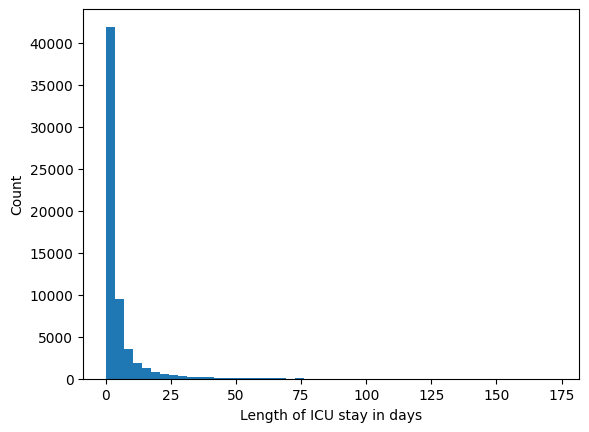

In [ ]:
# Compute the mean and median LOS
avg_los = icu_stays_df["LOS"].mean()
median_los = icu_stays_df["LOS"].median()
print(f'The average length of ICU stay in days: {avg_los:.2f}')
print(f'The median length of ICU stay in days: {median_los:.2f}')

# Plot the distribution
plt.hist(icu_stays_df["LOS"], bins=50)
plt.xlabel('Length of ICU stay in days')
plt.ylabel('Count')

In [ ]:
# Get patients data
pat_df = pd.read_csv(dir_path + "PATIENTS.csv", parse_dates=['DOB', 'DOD'])
pat_df.head()

#  Please note that dates of birth for patients aged over 89 were shifted 
# to obscure their true age and comply with HIPAA regulations: 
# these patients appear in the database with ages of over 300 years.

,ROW_ID,SUBJECT_ID,GENDER,DOB,DOD,DOD_HOSP,DOD_SSN,EXPIRE_FLAG
0,234,249,F,2075-03-13,NaT,NaN,NaN,0
1,235,250,F,2164-12-27,2188-11-22,2188-11-22 00:00:00,NaN,1
2,236,251,M,2090-03-15,NaT,NaN,NaN,0
3,237,252,M,2078-03-06,NaT,NaN,NaN,0
4,238,253,F,2089-11-26,NaT,NaN,NaN,0


Text(0, 0.5, 'Count')

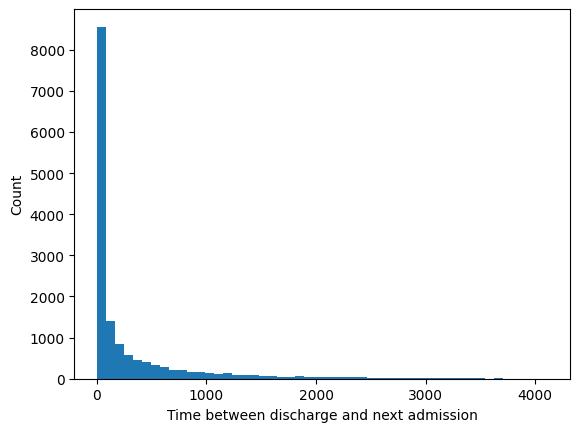

In [ ]:
# Link ICU stays and patients tables
icu_pat = pd.merge(icu_stays_df, pat_df, how='inner', on='SUBJECT_ID')
icu_pat.sort_values(by=['SUBJECT_ID', 'OUTTIME'], ascending=[True, False], inplace=True)

# Time to next admission (discharge to admission)
icu_pat['DAYS_TO_NEXT'] = (icu_pat.groupby(['SUBJECT_ID']).shift(1)['INTIME'] - icu_pat['OUTTIME']).dt.days
# Plot the distribution
plt.hist(icu_pat['DAYS_TO_NEXT'], bins=50)
plt.xlabel('Time between discharge and next admission')
plt.ylabel('Count')



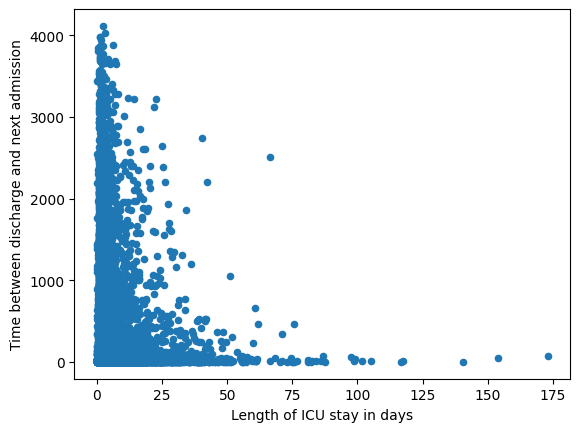

In [ ]:
# scatter plot
icu_pat.plot.scatter(x='LOS', y='DAYS_TO_NEXT')
plt.xlabel('Length of ICU stay in days')
plt.ylabel('Time between discharge and next admission')
# display the plot
plt.show()

During analysis, we utilized Google Colab Pro to improve the speed. We first confirm if we are using GPU and check the info of the GPU being utilized.

In [ ]:
import tensorflow as tf
print(tf.test.gpu_device_name())

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

/device:GPU:0
Sun May  7 18:02:07 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   53C    P0    30W /  70W |    373MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                          

Determine the Memory being utilized

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


Now, we will get started with setting up the data. 
First, we requested access to PhysioNet, downloaded the MIMIC-III dataset, and then preprocessed the data on our local machines. 
Then we zipped the data files containing processed data and uploaded this zipped file to the root directory of our Google Drive. 
Now, we set up a connection to our data in Google Drive. 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Unzip data.zip located in Google Drive root and move to Google Colab locally

In [ ]:
!apt install unzip
!unzip /content/drive/MyDrive/data.zip -d /content/
!unzip /content/drive/MyDrive/logdir.zip -d /content/

Reading package lists... Done
Building dependency tree       
Reading state information... Done
unzip is already the newest version (6.0-25ubuntu1.1).
0 upgraded, 0 newly installed, 0 to remove and 24 not upgraded.
Archive:  /content/drive/MyDrive/data.zip
replace /content/data/chartevents_reduced.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: Archive:  /content/drive/MyDrive/logdir.zip
replace /content/logdir/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

First, we install and import all necessary dependencies. 

In [ ]:
pip install torchdiffeq

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import torch
import math
import random 
import os
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import pandas as pd
import pickle
import scipy.stats as st
import torch.utils.data as utils
from __future__ import print_function
from pdb import set_trace as bp
from math import pi
from torchdiffeq import odeint, odeint_adjoint
from pdb import set_trace as bp
from torch.autograd import Variable
from tqdm import tqdm
from time import time
from sklearn.metrics import accuracy_score, confusion_matrix, average_precision_score, roc_auc_score, f1_score
from sklearn.metrics import *
from sklearn.calibration import calibration_curve


Set Hyperparameters

In [ ]:
'''Hyperparameters'''
# data
mimic_dir = '../../MIMIC-III Clinical Database/uncompressed/'
#data_dir = '/content/drive/MyDrive/data/' # log directory  
data_dir = 'data/' 
logdir = '/content/drive/MyDrive/logdir/' # log directory  
#logdir = 'logdir/' 

# model
min_count = 100 # words whose occurred less than min_cnt are encoded as OTHER
  
# training
batch_size = 128
num_epochs = 10
#adjusted from 80 epochs
dropout_rate = 0.5
patience = 10 # early stopping

# which data to load
# on_the_cloud = False
all_train = False
# all_train = True

# network variants
# net_variant = 'birnn_concat_time_delta'
# net_variant = 'birnn_concat_time_delta_attention'
# net_variant = 'birnn_time_decay'#
# net_variant = 'birnn_time_decay_attention'#
# net_variant = 'ode_birnn'#
# net_variant = 'ode_birnn_attention'#
net_variant = 'ode_attention'#
# net_variant = 'attention_concat_time'
#net_variant = 'birnn_ode_decay'
# net_variant = 'birnn_ode_decay_attention'
# net_variant = 'mce_attention'#
# net_variant = 'mce_birnn'#
# net_variant = 'mce_birnn_attention'#

# bootstrapping
np_seed = 1234
bootstrap_samples = 100

# bayesian network
pi = 0.5
sigma1 = math.exp(-0)
sigma2 = math.exp(-6)
samples = 1
test_samples = 10

Data Load

In [ ]:
'''
Aug 2018 by Sebastiano Barbieri
s.barbieri@unsw.edu.au
whitman5@illinois.edu adapted section below to test models with random data removed
'''
def get_data(data, type):
  # Data
  static       = data['static'].astype('float32')
  label        = data['label'].astype('float32')
  dp           = data['dp'].astype('int64') # diagnoses/procedures
  cp           = data['cp'].astype('int64') # charts/prescriptions
  dp_times     = data['dp_times'].astype('float32')
  cp_times     = data['cp_times'].astype('float32')
  train_ids    = data['train_ids']
  validate_ids = data['validate_ids']
  test_ids     = data['test_ids']  

  # used for testing the models with 10 percent of data removed. 4500 is ~10 % of the data

  #r = random.sample(range(0, len(train_ids)-1), 4500)
  #o = np.full(len(train_ids), True)
  #z = np.full(4500, False)
  #np.put(o, r, z)
  #train_ids = train_ids * o
  #test_ids = test_ids * o

  if (type == 'TRAIN'):
    ids = train_ids
  elif (type == 'VALIDATE'):
    ids = validate_ids
  elif (type == 'TEST'):
    ids = test_ids
  elif (type == 'ALL'):
    ids = np.full_like(label, True, dtype=bool)

  static   = static[ids, :]
  label    = label[ids]
  dp       = dp[ids, :]
  cp       = cp[ids, :]
  dp_times = dp_times[ids, :]
  cp_times = cp_times[ids, :]
  
  return static, dp, cp, dp_times, cp_times, label


def get_dictionaries(data):
  return data['static_vars'], data['dict_dp'][()], data['dict_cp'][()]


def num_static(data):
  return data['static_vars'].shape[0]
  

def vocab_sizes(data):
  return data['dp'].max()+1, data['cp'].max()+1

  
def get_trainloader(data, type, shuffle=True, idx=None):
  # Data
  static, dp, cp, dp_times, cp_times, label = get_data(data, type)

  # Bootstrap
  if idx is not None:
    static, dp, cp, dp_times, cp_times, label = static[idx], dp[idx], cp[idx], dp_times[idx], cp_times[idx], label[idx]

  # Compute total batch count
  num_batches = len(label) // batch_size
  
  # Create dataset
  dataset = utils.TensorDataset(torch.from_numpy(static), 
                                torch.from_numpy(dp),
                                torch.from_numpy(cp),
                                torch.from_numpy(dp_times),
                                torch.from_numpy(cp_times),
                                torch.from_numpy(label))

  # Create batch queues
  trainloader = utils.DataLoader(dataset,
                                 batch_size = batch_size, 
                                 shuffle = shuffle,
                                 sampler = None,
                                 num_workers = 2,
                                 drop_last = True)
                                 
  # Weight of positive samples for training
  pos_weight = torch.tensor((len(label) - np.sum(label))/np.sum(label))
  
  return trainloader, num_batches, pos_weight
  
  
if __name__ == '__main__':
  print('Load data...')
  data = np.load(data_dir + 'data_arrays.npz')
  trainloader, num_batches, pos_weight = get_trainloader(data, 'TRAIN')
  # vocab_diagnoses, vocab_procedures, vocab_prescriptions = vocab_sizes(data)
  

Load data...


ODE Modules

In [ ]:
'''
Adapted from https://github.com/EmilienDupont/augmented-neural-odes/blob/master/anode/models.py
'''

MAX_NUM_STEPS = 1000  # Maximum number of steps for ODE solver

class ODEFunc(nn.Module):
    """MLP modeling the derivative of ODE system.
    Parameters
    ----------
    device : torch.device
    data_dim : int
        Dimension of data.
    hidden_dim : int
        Dimension of hidden layers.
    augment_dim: int
        Dimension of augmentation. If 0 does not augment ODE, otherwise augments
        it with augment_dim dimensions.
    time_dependent : bool
        If True adds time as input, making ODE time dependent.
    non_linearity : string
        One of 'relu' and 'softplus'
    """
    def __init__(self, device, data_dim, hidden_dim, augment_dim=0,
                 time_dependent=False, non_linearity='relu'):
        super(ODEFunc, self).__init__()
        self.device = device
        self.augment_dim = augment_dim
        self.data_dim = data_dim
        self.input_dim = data_dim + augment_dim
        self.hidden_dim = hidden_dim
        self.nfe = 0  # Number of function evaluations
        self.time_dependent = time_dependent

        if time_dependent:
            self.fc1 = nn.Linear(self.input_dim + 1, hidden_dim)
        else:
            self.fc1 = nn.Linear(self.input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, self.input_dim)

        if non_linearity == 'relu':
            self.non_linearity = nn.ReLU(inplace=True)
        elif non_linearity == 'softplus':
            self.non_linearity = nn.Softplus()

    def forward(self, t, x):
        """
        Parameters
        ----------
        t : torch.Tensor
            Current time. Shape (1,).
        x : torch.Tensor
            Shape (batch_size, input_dim)
        """
        # Forward pass of model corresponds to one function evaluation, so
        # increment counter
        self.nfe += 1
        if self.time_dependent:
            # Shape (batch_size, 1)
            t_vec = torch.ones(x.shape[0], 1).to(self.device) * t
            # Shape (batch_size, data_dim + 1)
            t_and_x = torch.cat([t_vec, x], 1)
            # Shape (batch_size, hidden_dim)
            out = self.fc1(t_and_x)
        else:
            out = self.fc1(x)
        out = self.non_linearity(out)
        out = self.fc2(out)
        out = self.non_linearity(out)
        out = self.fc3(out)
        return out


class ODEBlock(nn.Module):
    """Solves ODE defined by odefunc.
    Parameters
    ----------
    device : torch.device
    odefunc : ODEFunc instance or anode.conv_models.ConvODEFunc instance
        Function defining dynamics of system.
    is_conv : bool
        If True, treats odefunc as a convolutional model.
    tol : float
        Error tolerance.
    adjoint : bool
        If True calculates gradient with adjoint method, otherwise
        backpropagates directly through operations of ODE solver.
    """
    def __init__(self, device, odefunc, is_conv=False, tol=1e-3, adjoint=False):
        super(ODEBlock, self).__init__()
        self.adjoint = adjoint
        self.device = device
        self.is_conv = is_conv
        self.odefunc = odefunc
        self.tol = tol

    def forward(self, x, eval_times=None):
        """Solves ODE starting from x.
        Parameters
        ----------
        x : torch.Tensor
            Shape (batch_size, self.odefunc.data_dim)
        eval_times : None or torch.Tensor
            If None, returns solution of ODE at final time t=1. If torch.Tensor
            then returns full ODE trajectory evaluated at points in eval_times.
        """
        # Forward pass corresponds to solving ODE, so reset number of function
        # evaluations counter
        self.odefunc.nfe = 0
        
        if eval_times is None:
            integration_time = torch.tensor([0, 1]).float().type_as(x)
        else:
            integration_time = eval_times.type_as(x)


        if self.odefunc.augment_dim > 0:
            if self.is_conv:
                # Add augmentation
                batch_size, channels, height, width = x.shape
                aug = torch.zeros(batch_size, self.odefunc.augment_dim,
                                  height, width).to(self.device)
                # Shape (batch_size, channels + augment_dim, height, width)
                x_aug = torch.cat([x, aug], 1)
            else:
                # Add augmentation
                aug = torch.zeros(x.shape[0], self.odefunc.augment_dim).to(self.device)
                # Shape (batch_size, data_dim + augment_dim)
                x_aug = torch.cat([x, aug], 1)
        else:
            x_aug = x

        if self.adjoint:
            out = odeint_adjoint(self.odefunc, x_aug, integration_time,
                                 rtol=self.tol, atol=self.tol, method='euler',
                                 options={'max_num_steps': MAX_NUM_STEPS})
        else:
            out = odeint(self.odefunc, x_aug, integration_time,
                         rtol=self.tol, atol=self.tol, method='euler',
                         options={'max_num_steps': MAX_NUM_STEPS})

        if eval_times is None:
            return out[1]  # Return only final time
        else:
            return out


class ODENet(nn.Module):
    """An ODEBlock followed by a Linear layer.
    Parameters
    ----------
    device : torch.device
    data_dim : int
        Dimension of data.
    hidden_dim : int
        Dimension of hidden layers.
    output_dim : int
        Dimension of output after hidden layer. Should be 1 for regression or
        num_classes for classification.
    augment_dim: int
        Dimension of augmentation. If 0 does not augment ODE, otherwise augments
        it with augment_dim dimensions.
    time_dependent : bool
        If True adds time as input, making ODE time dependent.
    non_linearity : string
        One of 'relu' and 'softplus'
    tol : float
        Error tolerance.
    adjoint : bool
        If True calculates gradient with adjoint method, otherwise
        backpropagates directly through operations of ODE solver.
    """
    def __init__(self, device, data_dim, hidden_dim, output_dim=1,
                 augment_dim=0, time_dependent=False, non_linearity='relu',
                 tol=1e-3, adjoint=False):
        super(ODENet, self).__init__()
        self.device = device
        self.data_dim = data_dim
        self.hidden_dim = hidden_dim
        self.augment_dim = augment_dim
        self.output_dim = output_dim
        self.time_dependent = time_dependent
        self.tol = tol

        odefunc = ODEFunc(device, data_dim, hidden_dim, augment_dim,
                          time_dependent, non_linearity)

        self.odeblock = ODEBlock(device, odefunc, tol=tol, adjoint=adjoint)

    def forward(self, x, eval_times=None):
        features = self.odeblock(x, eval_times)
        return features
        

Modules

In [ ]:
class Attention(torch.nn.Module):
  """
  Dot-product attention module.
  
  Args:
    inputs: A `Tensor` with embeddings in the last dimension.
    mask: A `Tensor`. Dimensions are the same as inputs but without the embedding dimension.
      Values are 0 for 0-padding in the input and 1 elsewhere.

  Returns:
    outputs: The input `Tensor` whose embeddings in the last dimension have undergone a weighted average.
      The second-last dimension of the `Tensor` is removed.
    attention_weights: weights given to each embedding.
  """
  def __init__(self, embedding_dim):
    super(Attention, self).__init__()
    self.context = nn.Parameter(torch.Tensor(embedding_dim)) # context vector
    self.linear_hidden = nn.Linear(embedding_dim, embedding_dim)
    self.reset_parameters()
    
  def reset_parameters(self):
    nn.init.normal_(self.context)

  def forward(self, inputs, mask):
    # Hidden representation of embeddings (no change in dimensions)
    hidden = torch.tanh(self.linear_hidden(inputs))
    # Compute weight of each embedding
    importance = torch.sum(hidden * self.context, dim=-1)
    importance = importance.masked_fill(mask == 0, -1e9)
    # Softmax so that weights sum up to one
    attention_weights = F.softmax(importance, dim=-1)
    # Weighted sum of embeddings
    weighted_projection = inputs * torch.unsqueeze(attention_weights, dim=-1)
    # Output
    outputs = torch.sum(weighted_projection, dim=-2)
    return outputs, attention_weights


class GRUExponentialDecay(nn.Module):
  """
  GRU RNN module where the hidden state decays exponentially
  (see e.g. Che et al. 2018, Recurrent Neural Networks for Multivariate Time Series
  with Missing Values).
  
  Args:
    inputs: A `Tensor` with embeddings in the last dimension.
    times: A `Tensor` with the same shape as inputs containing the recorded times (but no embedding dimension).

  Returns:
    outs: Hidden states of the RNN.
  """
  def __init__(self, input_size, hidden_size, bias=True):
    super(GRUExponentialDecay, self).__init__()
    self.input_size = input_size
    self.hidden_size = hidden_size
    self.gru_cell = nn.GRUCell(input_size, hidden_size)
    self.decays = nn.Parameter(torch.Tensor(hidden_size)) # exponential decays vector
  
  def forward(self, inputs, times):
    # initializing and then calling cuda() later isn't working for some reason
    if torch.cuda.is_available():
      hn = torch.zeros(inputs.size(0), self.hidden_size).cuda() # batch_size x hidden_size
      outs = torch.zeros(inputs.size(0), inputs.size(1), self.hidden_size).cuda() # batch_size x seq_len x hidden_size
    else:
      hn = torch.zeros(inputs.size(0), self.hidden_size) # batch_size x hidden_size
      outs = torch.zeros(inputs.size(0), inputs.size(1), self.hidden_size) # batch_size x seq_len x hidden_size
    
    # this is slow
    for seq in range(inputs.size(1)):
      hn = self.gru_cell(inputs[:,seq,:], hn)
      outs[:,seq,:] = hn
      hn = hn*torch.exp(-torch.clamp(torch.unsqueeze(times[:,seq], dim=-1)*self.decays, min=0))
    return outs


class GRUOdeDecay(nn.Module):
  """
  GRU RNN module where the hidden state decays according to an ODE.
  (see Rubanova et al. 2019, Latent ODEs for Irregularly-Sampled Time Series)
  
  Args:
    inputs: A `Tensor` with embeddings in the last dimension.
    times: A `Tensor` with the same shape as inputs containing the recorded times (but no embedding dimension).

  Returns:
    outs: Hidden states of the RNN.
  """
  def __init__(self, input_size, hidden_size, bias=True):
    super(GRUOdeDecay, self).__init__()
    self.input_size = input_size
    self.hidden_size = hidden_size
    self.gru_cell = nn.GRUCell(input_size, hidden_size)
    self.decays = nn.Parameter(torch.Tensor(hidden_size)) # exponential decays vector
    
    # ODE
    self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    self.ode_net = ODENet(self.device, self.input_size, self.input_size, output_dim=self.input_size, augment_dim=0, time_dependent=False, non_linearity='softplus', tol=1e-3, adjoint=True)
  
  def forward(self, inputs, times):
    # initializing and then calling cuda() later isn't working for some reason
    if torch.cuda.is_available():
      hn = torch.zeros(inputs.size(0), self.hidden_size).cuda() # batch_size x hidden_size
      outs = torch.zeros(inputs.size(0), inputs.size(1), self.hidden_size).cuda() # batch_size x seq_len x hidden_size
    else:
      hn = torch.zeros(inputs.size(0), self.hidden_size) # batch_size x hidden_size
      outs = torch.zeros(inputs.size(0), inputs.size(1), self.hidden_size) # batch_size x seq_len x hidden_size

    # this is slow
    for seq in range(inputs.size(1)):
      hn = self.gru_cell(inputs[:,seq,:], hn)
      outs[:,seq,:] = hn
      
      times_unique, inverse_indices = torch.unique(times[:,seq], sorted=True, return_inverse=True)
      if times_unique.size(0) > 1:
        hn = self.ode_net(hn, times_unique)
        hn = hn[inverse_indices, torch.arange(0, inverse_indices.size(0)), :]
    return outs


def abs_time_to_delta(times):
  delta = torch.cat((torch.unsqueeze(times[:, 0], dim=-1), times[:, 1:] - times[:, :-1]), dim=1)
  delta = torch.clamp(delta, min=0)
  return delta


if net_variant == 'birnn_concat_time_delta':
  # GRU
  class Net(nn.Module):
    def __init__(self, num_static, num_dp_codes, num_cp_codes):
      super(Net, self).__init__()
      
      # Embedding dimensions
      self.embed_dp_dim = int(np.ceil(num_dp_codes**0.25))
      self.embed_cp_dim = int(np.ceil(num_cp_codes**0.25))

      # Embedding layers
      self.embed_dp = nn.Embedding(num_embeddings=num_dp_codes, embedding_dim=self.embed_dp_dim, padding_idx=0)
      self.embed_cp = nn.Embedding(num_embeddings=num_cp_codes, embedding_dim=self.embed_cp_dim, padding_idx=0)

      # GRU layers
      self.gru_dp_fw = nn.GRU(input_size=self.embed_dp_dim+1, hidden_size=self.embed_dp_dim+1, num_layers=1, batch_first=True)
      self.gru_cp_fw = nn.GRU(input_size=self.embed_cp_dim+1, hidden_size=self.embed_cp_dim+1, num_layers=1, batch_first=True)
      self.gru_dp_bw = nn.GRU(input_size=self.embed_dp_dim+1, hidden_size=self.embed_dp_dim+1, num_layers=1, batch_first=True)
      self.gru_cp_bw = nn.GRU(input_size=self.embed_cp_dim+1, hidden_size=self.embed_cp_dim+1, num_layers=1, batch_first=True)
      
      # Fully connected output
      self.fc_dp  = nn.Linear(2*(self.embed_dp_dim+1), 1)
      self.fc_cp  = nn.Linear(2*(self.embed_cp_dim+1), 1)
      self.fc_all = nn.Linear(num_static + 2, 1)
      
      # Others
      self.dropout = nn.Dropout(p=0.5)

    def forward(self, stat, dp, cp, dp_t, cp_t):
      # Compute time delta
      ## output dim: batch_size x seq_len
      dp_t_delta_fw = abs_time_to_delta(dp_t)
      cp_t_delta_fw = abs_time_to_delta(cp_t)
      dp_t_delta_bw = abs_time_to_delta(torch.flip(dp_t, [1]))
      cp_t_delta_bw = abs_time_to_delta(torch.flip(cp_t, [1]))    
    
      # Embedding
      ## output dim: batch_size x seq_len x embedding_dim
      embedded_dp_fw = self.embed_dp(dp)
      embedded_cp_fw = self.embed_cp(cp)
      embedded_dp_bw = torch.flip(embedded_dp_fw, [1])
      embedded_cp_bw = torch.flip(embedded_cp_fw, [1])
      
      # Concatate with time
      ## output dim: batch_size x seq_len x (embedding_dim+1)
      concat_dp_fw = torch.cat((embedded_dp_fw, torch.unsqueeze(dp_t_delta_fw, dim=-1)), dim=-1)
      concat_cp_fw = torch.cat((embedded_cp_fw, torch.unsqueeze(cp_t_delta_fw, dim=-1)), dim=-1)
      concat_dp_bw = torch.cat((embedded_dp_bw, torch.unsqueeze(dp_t_delta_bw, dim=-1)), dim=-1)
      concat_cp_bw = torch.cat((embedded_cp_bw, torch.unsqueeze(cp_t_delta_bw, dim=-1)), dim=-1)
      ## Dropout
      concat_dp_fw = self.dropout(concat_dp_fw)
      concat_cp_fw = self.dropout(concat_cp_fw)
      concat_dp_bw = self.dropout(concat_dp_bw)
      concat_cp_bw = self.dropout(concat_cp_bw)
      
      # GRU
      ## output dim rnn:        batch_size x seq_len x (embedding_dim+1)
      ## output dim rnn_hidden: batch_size x 1 x (embedding_dim+1)
      rnn_dp_fw, rnn_hidden_dp_fw = self.gru_dp_fw(concat_dp_fw)
      rnn_cp_fw, rnn_hidden_cp_fw = self.gru_cp_fw(concat_cp_fw)
      rnn_dp_bw, rnn_hidden_dp_bw = self.gru_dp_bw(concat_dp_bw)
      rnn_cp_bw, rnn_hidden_cp_bw = self.gru_cp_bw(concat_cp_bw)      
      ## output dim rnn_hidden: batch_size x (embedding_dim+1)
      rnn_hidden_dp_fw = rnn_hidden_dp_fw.view(-1, self.embed_dp_dim+1)
      rnn_hidden_cp_fw = rnn_hidden_cp_fw.view(-1, self.embed_cp_dim+1)
      rnn_hidden_dp_bw = rnn_hidden_dp_bw.view(-1, self.embed_dp_dim+1)
      rnn_hidden_cp_bw = rnn_hidden_cp_bw.view(-1, self.embed_cp_dim+1)
      ## concatenate forward and backward: batch_size x 2*(embedding_dim+1)
      rnn_hidden_dp = torch.cat((rnn_hidden_dp_fw, rnn_hidden_dp_bw), dim=-1)
      rnn_hidden_cp = torch.cat((rnn_hidden_cp_fw, rnn_hidden_cp_bw), dim=-1)
      
      # Scores
      score_dp = self.fc_dp(self.dropout(rnn_hidden_dp))
      score_cp = self.fc_cp(self.dropout(rnn_hidden_cp))

      # Concatenate to variable collection
      all = torch.cat((stat, score_dp, score_cp), dim=1)
      
      # Final linear projection
      out = self.fc_all(self.dropout(all)).squeeze()

      return out, []


elif net_variant == 'birnn_concat_time_delta_attention':
  # GRU
  class Net(nn.Module):
    def __init__(self, num_static, num_dp_codes, num_cp_codes):
      super(Net, self).__init__()
      
      # Embedding dimensions
      self.embed_dp_dim = int(np.ceil(num_dp_codes**0.25))
      self.embed_cp_dim = int(np.ceil(num_cp_codes**0.25))

      # Embedding layers
      self.embed_dp = nn.Embedding(num_embeddings=num_dp_codes, embedding_dim=self.embed_dp_dim, padding_idx=0)
      self.embed_cp = nn.Embedding(num_embeddings=num_cp_codes, embedding_dim=self.embed_cp_dim, padding_idx=0)

      # GRU layers
      self.gru_dp_fw = nn.GRU(input_size=self.embed_dp_dim+1, hidden_size=self.embed_dp_dim+1, num_layers=1, batch_first=True)
      self.gru_cp_fw = nn.GRU(input_size=self.embed_cp_dim+1, hidden_size=self.embed_cp_dim+1, num_layers=1, batch_first=True)
      self.gru_dp_bw = nn.GRU(input_size=self.embed_dp_dim+1, hidden_size=self.embed_dp_dim+1, num_layers=1, batch_first=True)
      self.gru_cp_bw = nn.GRU(input_size=self.embed_cp_dim+1, hidden_size=self.embed_cp_dim+1, num_layers=1, batch_first=True)

      # Attention layers
      self.attention_dp = Attention(embedding_dim=2*(self.embed_dp_dim+1)) #+1 for the concatenated time
      self.attention_cp = Attention(embedding_dim=2*(self.embed_cp_dim+1))
            
      # Fully connected output
      self.fc_dp  = nn.Linear(2*(self.embed_dp_dim+1), 1)
      self.fc_cp  = nn.Linear(2*(self.embed_cp_dim+1), 1)
      self.fc_all = nn.Linear(num_static + 2, 1)
      
      # Others
      self.dropout = nn.Dropout(p=0.5)

    def forward(self, stat, dp, cp, dp_t, cp_t):
      # Compute time delta
      ## output dim: batch_size x seq_len
      dp_t_delta_fw = abs_time_to_delta(dp_t)
      cp_t_delta_fw = abs_time_to_delta(cp_t)
      dp_t_delta_bw = abs_time_to_delta(torch.flip(dp_t, [1]))
      cp_t_delta_bw = abs_time_to_delta(torch.flip(cp_t, [1]))    
    
      # Embedding
      ## output dim: batch_size x seq_len x embedding_dim
      embedded_dp_fw = self.embed_dp(dp)
      embedded_cp_fw = self.embed_cp(cp)
      embedded_dp_bw = torch.flip(embedded_dp_fw, [1])
      embedded_cp_bw = torch.flip(embedded_cp_fw, [1])
      
      # Concatate with time
      ## output dim: batch_size x seq_len x (embedding_dim+1)
      concat_dp_fw = torch.cat((embedded_dp_fw, torch.unsqueeze(dp_t_delta_fw, dim=-1)), dim=-1)
      concat_cp_fw = torch.cat((embedded_cp_fw, torch.unsqueeze(cp_t_delta_fw, dim=-1)), dim=-1)
      concat_dp_bw = torch.cat((embedded_dp_bw, torch.unsqueeze(dp_t_delta_bw, dim=-1)), dim=-1)
      concat_cp_bw = torch.cat((embedded_cp_bw, torch.unsqueeze(cp_t_delta_bw, dim=-1)), dim=-1)
      ## Dropout
      concat_dp_fw = self.dropout(concat_dp_fw)
      concat_cp_fw = self.dropout(concat_cp_fw)
      concat_dp_bw = self.dropout(concat_dp_bw)
      concat_cp_bw = self.dropout(concat_cp_bw)
      
      # GRU
      ## output dim rnn:        batch_size x seq_len x (embedding_dim+1)
      ## output dim rnn_hidden: batch_size x 1 x (embedding_dim+1)
      rnn_dp_fw, rnn_hidden_dp_fw = self.gru_dp_fw(concat_dp_fw)
      rnn_cp_fw, rnn_hidden_cp_fw = self.gru_cp_fw(concat_cp_fw)
      rnn_dp_bw, rnn_hidden_dp_bw = self.gru_dp_bw(concat_dp_bw)
      rnn_cp_bw, rnn_hidden_cp_bw = self.gru_cp_bw(concat_cp_bw)      
      # concatenate forward and backward
      ## output dim: batch_size x seq_len x 2*(embedding_dim+1)
      rnn_dp = torch.cat((rnn_dp_fw, torch.flip(rnn_dp_bw, [1])), dim=-1)
      rnn_cp = torch.cat((rnn_cp_fw, torch.flip(rnn_cp_bw, [1])), dim=-1)

      # Attention
      ## output dim: batch_size x 2*(embedding_dim+1)
      attended_dp, weights_dp = self.attention_dp(rnn_dp, (dp > 0).float())
      attended_cp, weights_cp = self.attention_cp(rnn_cp, (cp > 0).float())
      
      # Scores
      score_dp = self.fc_dp(self.dropout(attended_dp))
      score_cp = self.fc_cp(self.dropout(attended_cp))

      # Concatenate to variable collection
      all = torch.cat((stat, score_dp, score_cp), dim=1)
      
      # Final linear projection
      out = self.fc_all(self.dropout(all)).squeeze()

      return out, []


elif net_variant == 'birnn_time_decay':
  # GRU
  class Net(nn.Module):
    def __init__(self, num_static, num_dp_codes, num_cp_codes):
      super(Net, self).__init__()
      
      # Embedding dimensions
      self.embed_dp_dim = int(np.ceil(num_dp_codes**0.25))+1
      self.embed_cp_dim = int(np.ceil(num_cp_codes**0.25))+1

      # Embedding layers
      self.embed_dp = nn.Embedding(num_embeddings=num_dp_codes, embedding_dim=self.embed_dp_dim, padding_idx=0)
      self.embed_cp = nn.Embedding(num_embeddings=num_cp_codes, embedding_dim=self.embed_cp_dim, padding_idx=0)

      # GRU layers
      self.gru_dp_fw = GRUExponentialDecay(input_size=self.embed_dp_dim, hidden_size=self.embed_dp_dim)
      self.gru_cp_fw = GRUExponentialDecay(input_size=self.embed_cp_dim, hidden_size=self.embed_cp_dim)
      self.gru_dp_bw = GRUExponentialDecay(input_size=self.embed_dp_dim, hidden_size=self.embed_dp_dim)
      self.gru_cp_bw = GRUExponentialDecay(input_size=self.embed_cp_dim, hidden_size=self.embed_cp_dim)
      
      # Fully connected output
      self.fc_dp  = nn.Linear(2*self.embed_dp_dim, 1)
      self.fc_cp  = nn.Linear(2*self.embed_cp_dim, 1)
      self.fc_all = nn.Linear(num_static + 2, 1)
      
      # Others
      self.dropout = nn.Dropout(p=0.5)

    def forward(self, stat, dp, cp, dp_t, cp_t):
      # Compute time delta
      ## output dim: batch_size x seq_len
      dp_t_delta_fw = abs_time_to_delta(dp_t)
      cp_t_delta_fw = abs_time_to_delta(cp_t)
      dp_t_delta_bw = abs_time_to_delta(torch.flip(dp_t, [1]))
      cp_t_delta_bw = abs_time_to_delta(torch.flip(cp_t, [1]))    
    
      # Embedding
      ## output dim: batch_size x seq_len x embedding_dim
      embedded_dp_fw = self.embed_dp(dp)
      embedded_cp_fw = self.embed_cp(cp)
      embedded_dp_bw = torch.flip(embedded_dp_fw, [1])
      embedded_cp_bw = torch.flip(embedded_cp_fw, [1])
      ## Dropout
      embedded_dp_fw = self.dropout(embedded_dp_fw)
      embedded_cp_fw = self.dropout(embedded_cp_fw)
      embedded_dp_bw = self.dropout(embedded_dp_bw)
      embedded_cp_bw = self.dropout(embedded_cp_bw)
      
      # GRU
      ## output dim rnn:        batch_size x seq_len x embedding_dim
      rnn_dp_fw = self.gru_dp_fw(embedded_dp_fw, dp_t_delta_fw)
      rnn_cp_fw = self.gru_cp_fw(embedded_cp_fw, cp_t_delta_fw)
      rnn_dp_bw = self.gru_dp_bw(embedded_dp_bw, dp_t_delta_bw)
      rnn_cp_bw = self.gru_cp_bw(embedded_cp_bw, cp_t_delta_bw)      
      ## output dim rnn_hidden: batch_size x embedding_dim
      rnn_dp_fw = rnn_dp_fw[:,-1,:]
      rnn_cp_fw = rnn_cp_fw[:,-1,:]
      rnn_dp_bw = rnn_dp_bw[:,-1,:]
      rnn_cp_bw = rnn_cp_bw[:,-1,:]
      ## concatenate forward and backward: batch_size x 2*embedding_dim
      rnn_dp = torch.cat((rnn_dp_fw, rnn_dp_bw), dim=-1)
      rnn_cp = torch.cat((rnn_cp_fw, rnn_cp_bw), dim=-1)
      
      # Scores
      score_dp = self.fc_dp(self.dropout(rnn_dp))
      score_cp = self.fc_cp(self.dropout(rnn_cp))

      # Concatenate to variable collection
      all = torch.cat((stat, score_dp, score_cp), dim=1)
      
      # Final linear projection
      out = self.fc_all(self.dropout(all)).squeeze()

      return out, []


elif net_variant == 'birnn_time_decay_attention':
  # GRU
  class Net(nn.Module):
    def __init__(self, num_static, num_dp_codes, num_cp_codes):
      super(Net, self).__init__()
      
      # Embedding dimensions
      self.embed_dp_dim = int(np.ceil(num_dp_codes**0.25))+1
      self.embed_cp_dim = int(np.ceil(num_cp_codes**0.25))+1

      # Embedding layers
      self.embed_dp = nn.Embedding(num_embeddings=num_dp_codes, embedding_dim=self.embed_dp_dim, padding_idx=0)
      self.embed_cp = nn.Embedding(num_embeddings=num_cp_codes, embedding_dim=self.embed_cp_dim, padding_idx=0)

      # GRU layers
      self.gru_dp_fw = GRUExponentialDecay(input_size=self.embed_dp_dim, hidden_size=self.embed_dp_dim)
      self.gru_cp_fw = GRUExponentialDecay(input_size=self.embed_cp_dim, hidden_size=self.embed_cp_dim)
      self.gru_dp_bw = GRUExponentialDecay(input_size=self.embed_dp_dim, hidden_size=self.embed_dp_dim)
      self.gru_cp_bw = GRUExponentialDecay(input_size=self.embed_cp_dim, hidden_size=self.embed_cp_dim)

      # Attention layers
      self.attention_dp = Attention(embedding_dim=2*self.embed_dp_dim)
      self.attention_cp = Attention(embedding_dim=2*self.embed_cp_dim)
      
      # Fully connected output
      self.fc_dp  = nn.Linear(2*self.embed_dp_dim, 1)
      self.fc_cp  = nn.Linear(2*self.embed_cp_dim, 1)
      self.fc_all = nn.Linear(num_static + 2, 1)
      
      # Others
      self.dropout = nn.Dropout(p=0.5)

    def forward(self, stat, dp, cp, dp_t, cp_t):
      # Compute time delta
      ## output dim: batch_size x seq_len
      dp_t_delta_fw = abs_time_to_delta(dp_t)
      cp_t_delta_fw = abs_time_to_delta(cp_t)
      dp_t_delta_bw = abs_time_to_delta(torch.flip(dp_t, [1]))
      cp_t_delta_bw = abs_time_to_delta(torch.flip(cp_t, [1]))    
    
      # Embedding
      ## output dim: batch_size x seq_len x embedding_dim
      embedded_dp_fw = self.embed_dp(dp)
      embedded_cp_fw = self.embed_cp(cp)
      embedded_dp_bw = torch.flip(embedded_dp_fw, [1])
      embedded_cp_bw = torch.flip(embedded_cp_fw, [1])
      ## Dropout
      embedded_dp_fw = self.dropout(embedded_dp_fw)
      embedded_cp_fw = self.dropout(embedded_cp_fw)
      embedded_dp_bw = self.dropout(embedded_dp_bw)
      embedded_cp_bw = self.dropout(embedded_cp_bw)
      
      # GRU
      ## output dim rnn:        batch_size x seq_len x embedding_dim
      rnn_dp_fw = self.gru_dp_fw(embedded_dp_fw, dp_t_delta_fw)
      rnn_cp_fw = self.gru_cp_fw(embedded_cp_fw, cp_t_delta_fw)
      rnn_dp_bw = self.gru_dp_bw(embedded_dp_bw, dp_t_delta_bw)
      rnn_cp_bw = self.gru_cp_bw(embedded_cp_bw, cp_t_delta_bw)
      # concatenate forward and backward
      ## output dim: batch_size x seq_len x 2*embedding_dim
      rnn_dp = torch.cat((rnn_dp_fw, torch.flip(rnn_dp_bw, [1])), dim=-1)
      rnn_cp = torch.cat((rnn_cp_fw, torch.flip(rnn_cp_bw, [1])), dim=-1)

      # Attention
      ## output dim: batch_size x 2*embedding_dim
      attended_dp, weights_dp = self.attention_dp(rnn_dp, (dp > 0).float())
      attended_cp, weights_cp = self.attention_cp(rnn_cp, (cp > 0).float())
      
      # Scores
      score_dp = self.fc_dp(self.dropout(attended_dp))
      score_cp = self.fc_cp(self.dropout(attended_cp))

      # Concatenate to variable collection
      all = torch.cat((stat, score_dp, score_cp), dim=1)
      
      # Final linear projection
      out = self.fc_all(self.dropout(all)).squeeze()

      return out, []


elif net_variant == 'attention_concat_time':
  # Attention Only
  class Net(nn.Module):
    def __init__(self, num_static, num_dp_codes, num_cp_codes):
      super(Net, self).__init__()
      
      # Embedding dimensions
      self.embed_dp_dim = int(2*np.ceil(num_dp_codes**0.25))
      self.embed_cp_dim = int(2*np.ceil(num_cp_codes**0.25))

      # Embedding layers
      self.embed_dp = nn.Embedding(num_embeddings=num_dp_codes, embedding_dim=self.embed_dp_dim, padding_idx=0)
      self.embed_cp = nn.Embedding(num_embeddings=num_cp_codes, embedding_dim=self.embed_cp_dim, padding_idx=0)
      
      # Attention layers
      self.attention_dp = Attention(embedding_dim=self.embed_dp_dim+1) #+1 for the concatenated time
      self.attention_cp = Attention(embedding_dim=self.embed_cp_dim+1)
      
      # Fully connected output
      self.fc_dp  = nn.Linear(self.embed_dp_dim+1, 1)
      self.fc_cp  = nn.Linear(self.embed_cp_dim+1, 1)
      self.fc_all = nn.Linear(num_static + 2, 1)
      
      # Others
      self.dropout = nn.Dropout(p=0.5)

    def forward(self, stat, dp, cp, dp_t, cp_t):
      # Embedding
      ## output dim: batch_size x seq_len x embedding_dim
      embedded_dp = self.embed_dp(dp)
      embedded_cp = self.embed_cp(cp)
      
      # Concatate with time
      ## output dim: batch_size x seq_len x (embedding_dim+1)
      concat_dp = torch.cat((embedded_dp, torch.unsqueeze(dp_t, dim=-1)), dim=-1)
      concat_cp = torch.cat((embedded_cp, torch.unsqueeze(cp_t, dim=-1)), dim=-1)
      ## Dropout
      concat_dp = self.dropout(concat_dp)
      concat_cp = self.dropout(concat_cp)
      
      # Attention
      ## output dim: batch_size x (embedding_dim+1)
      attended_dp, weights_dp = self.attention_dp(concat_dp, (dp > 0).float())
      attended_cp, weights_cp = self.attention_cp(concat_cp, (cp > 0).float())
      
      # Scores
      score_dp = self.fc_dp(self.dropout(attended_dp))
      score_cp = self.fc_cp(self.dropout(attended_cp))

      # Concatenate to variable collection
      all = torch.cat((stat, score_dp, score_cp), dim=1)
      
      # Final linear projection
      out = self.fc_all(self.dropout(all)).squeeze()

      return out, []


elif net_variant == 'ode_birnn':
  # Attention Only
  class Net(nn.Module):
    def __init__(self, num_static, num_dp_codes, num_cp_codes):
      super(Net, self).__init__()
      
      # Embedding dimensions
      self.embed_dp_dim = int(np.ceil(num_dp_codes**0.25))+1
      self.embed_cp_dim = int(np.ceil(num_cp_codes**0.25))+1

      # Embedding layers
      self.embed_dp = nn.Embedding(num_embeddings=num_dp_codes, embedding_dim=self.embed_dp_dim, padding_idx=0)
      self.embed_cp = nn.Embedding(num_embeddings=num_cp_codes, embedding_dim=self.embed_cp_dim, padding_idx=0)
      
      # ODE layers
      self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
      self.ode_dp = ODENet(self.device, self.embed_dp_dim, self.embed_dp_dim, output_dim=self.embed_dp_dim, augment_dim=0, time_dependent=False, non_linearity='softplus', tol=1e-3, adjoint=True)
      self.ode_cp = ODENet(self.device, self.embed_cp_dim, self.embed_cp_dim, output_dim=self.embed_cp_dim, augment_dim=0, time_dependent=False, non_linearity='softplus', tol=1e-3, adjoint=True)

      # GRU layers
      self.gru_dp_fw = nn.GRU(input_size=self.embed_dp_dim, hidden_size=self.embed_dp_dim, num_layers=1, batch_first=True)
      self.gru_cp_fw = nn.GRU(input_size=self.embed_cp_dim, hidden_size=self.embed_cp_dim, num_layers=1, batch_first=True)
      self.gru_dp_bw = nn.GRU(input_size=self.embed_dp_dim, hidden_size=self.embed_dp_dim, num_layers=1, batch_first=True)
      self.gru_cp_bw = nn.GRU(input_size=self.embed_cp_dim, hidden_size=self.embed_cp_dim, num_layers=1, batch_first=True)
      
      # Fully connected output
      self.fc_dp  = nn.Linear(2*self.embed_dp_dim, 1)
      self.fc_cp  = nn.Linear(2*self.embed_cp_dim, 1)
      self.fc_all = nn.Linear(num_static + 2, 1)
      
      # Others
      self.dropout = nn.Dropout(p=0.5)

    def forward(self, stat, dp, cp, dp_t, cp_t):
      # Embedding
      ## output dim: batch_size x seq_len x embedding_dim
      embedded_dp = self.embed_dp(dp)
      embedded_cp = self.embed_cp(cp)
      
      # ODE
      ## Round times
      dp_t = torch.round(100*dp_t)/100
      cp_t = torch.round(100*cp_t)/100
      
      embedded_dp_long = embedded_dp.view(-1, self.embed_dp_dim)
      dp_t_long = dp_t.view(-1)
      dp_t_long_unique, inverse_indices = torch.unique(dp_t_long, sorted=True, return_inverse=True)
      ode_dp_long = self.ode_dp(embedded_dp_long, dp_t_long_unique)
      ode_dp_long = ode_dp_long[inverse_indices, torch.arange(0, inverse_indices.size(0)), :]
      ode_dp = ode_dp_long.view(dp.size(0), dp.size(1), self.embed_dp_dim)

      embedded_cp_long = embedded_cp.view(-1, self.embed_cp_dim)
      cp_t_long = cp_t.view(-1)
      cp_t_long_unique, inverse_indices = torch.unique(cp_t_long, sorted=True, return_inverse=True)
      ode_cp_long = self.ode_cp(embedded_cp_long, cp_t_long_unique)
      ode_cp_long = ode_cp_long[inverse_indices, torch.arange(0, inverse_indices.size(0)), :]
      ode_cp = ode_cp_long.view(cp.size(0), cp.size(1), self.embed_cp_dim)
      
      ## Dropout
      ode_dp = self.dropout(ode_dp)
      ode_cp = self.dropout(ode_cp)

      # Forward and backward sequences
      ## output dim: batch_size x seq_len x embedding_dim
      ode_dp_fw = ode_dp
      ode_cp_fw = ode_cp
      ode_dp_bw = torch.flip(ode_dp_fw, [1])
      ode_cp_bw = torch.flip(ode_cp_fw, [1])
      
      # GRU
      ## output dim rnn:        batch_size x seq_len x embedding_dim
      ## output dim rnn_hidden: batch_size x 1 x embedding_dim
      rnn_dp_fw, rnn_hidden_dp_fw = self.gru_dp_fw(ode_dp_fw)
      rnn_cp_fw, rnn_hidden_cp_fw = self.gru_cp_fw(ode_cp_fw)
      rnn_dp_bw, rnn_hidden_dp_bw = self.gru_dp_bw(ode_dp_bw)
      rnn_cp_bw, rnn_hidden_cp_bw = self.gru_cp_bw(ode_cp_bw)      
      ## output dim rnn_hidden: batch_size x embedding_dim
      rnn_hidden_dp_fw = rnn_hidden_dp_fw.view(-1, self.embed_dp_dim)
      rnn_hidden_cp_fw = rnn_hidden_cp_fw.view(-1, self.embed_cp_dim)
      rnn_hidden_dp_bw = rnn_hidden_dp_bw.view(-1, self.embed_dp_dim)
      rnn_hidden_cp_bw = rnn_hidden_cp_bw.view(-1, self.embed_cp_dim)
      ## concatenate forward and backward: batch_size x 2*embedding_dim
      rnn_hidden_dp = torch.cat((rnn_hidden_dp_fw, rnn_hidden_dp_bw), dim=-1)
      rnn_hidden_cp = torch.cat((rnn_hidden_cp_fw, rnn_hidden_cp_bw), dim=-1)
      
      # Scores
      score_dp = self.fc_dp(self.dropout(rnn_hidden_dp))
      score_cp = self.fc_cp(self.dropout(rnn_hidden_cp))

      # Concatenate to variable collection
      all = torch.cat((stat, score_dp, score_cp), dim=1)
      
      # Final linear projection
      out = self.fc_all(self.dropout(all)).squeeze()

      return out, []


elif net_variant == 'ode_birnn_attention':
  # Attention Only
  class Net(nn.Module):
    def __init__(self, num_static, num_dp_codes, num_cp_codes):
      super(Net, self).__init__()
      
      # Embedding dimensions
      self.embed_dp_dim = int(np.ceil(num_dp_codes**0.25))+1
      self.embed_cp_dim = int(np.ceil(num_cp_codes**0.25))+1

      # Embedding layers
      self.embed_dp = nn.Embedding(num_embeddings=num_dp_codes, embedding_dim=self.embed_dp_dim, padding_idx=0)
      self.embed_cp = nn.Embedding(num_embeddings=num_cp_codes, embedding_dim=self.embed_cp_dim, padding_idx=0)
      
      # ODE layers
      self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
      self.ode_dp = ODENet(self.device, self.embed_dp_dim, self.embed_dp_dim, output_dim=self.embed_dp_dim, augment_dim=0, time_dependent=False, non_linearity='softplus', tol=1e-3, adjoint=True)
      self.ode_cp = ODENet(self.device, self.embed_cp_dim, self.embed_cp_dim, output_dim=self.embed_cp_dim, augment_dim=0, time_dependent=False, non_linearity='softplus', tol=1e-3, adjoint=True)

      # GRU layers
      self.gru_dp_fw = nn.GRU(input_size=self.embed_dp_dim, hidden_size=self.embed_dp_dim, num_layers=1, batch_first=True)
      self.gru_cp_fw = nn.GRU(input_size=self.embed_cp_dim, hidden_size=self.embed_cp_dim, num_layers=1, batch_first=True)
      self.gru_dp_bw = nn.GRU(input_size=self.embed_dp_dim, hidden_size=self.embed_dp_dim, num_layers=1, batch_first=True)
      self.gru_cp_bw = nn.GRU(input_size=self.embed_cp_dim, hidden_size=self.embed_cp_dim, num_layers=1, batch_first=True)

      # Attention layers
      self.attention_dp = Attention(embedding_dim=2*self.embed_dp_dim)
      self.attention_cp = Attention(embedding_dim=2*self.embed_cp_dim)
      
      # Fully connected output
      self.fc_dp  = nn.Linear(2*self.embed_dp_dim, 1)
      self.fc_cp  = nn.Linear(2*self.embed_cp_dim, 1)
      self.fc_all = nn.Linear(num_static + 2, 1)
      
      # Others
      self.dropout = nn.Dropout(p=0.5)

    def forward(self, stat, dp, cp, dp_t, cp_t):
      # Embedding
      ## output dim: batch_size x seq_len x embedding_dim
      embedded_dp = self.embed_dp(dp)
      embedded_cp = self.embed_cp(cp)
      
      # ODE
      ## Round times
      dp_t = torch.round(100*dp_t)/100
      cp_t = torch.round(100*cp_t)/100
      
      embedded_dp_long = embedded_dp.view(-1, self.embed_dp_dim)
      dp_t_long = dp_t.view(-1)
      dp_t_long_unique, inverse_indices = torch.unique(dp_t_long, sorted=True, return_inverse=True)
      ode_dp_long = self.ode_dp(embedded_dp_long, dp_t_long_unique)
      ode_dp_long = ode_dp_long[inverse_indices, torch.arange(0, inverse_indices.size(0)), :]
      ode_dp = ode_dp_long.view(dp.size(0), dp.size(1), self.embed_dp_dim)

      embedded_cp_long = embedded_cp.view(-1, self.embed_cp_dim)
      cp_t_long = cp_t.view(-1)
      cp_t_long_unique, inverse_indices = torch.unique(cp_t_long, sorted=True, return_inverse=True)
      ode_cp_long = self.ode_cp(embedded_cp_long, cp_t_long_unique)
      ode_cp_long = ode_cp_long[inverse_indices, torch.arange(0, inverse_indices.size(0)), :]
      ode_cp = ode_cp_long.view(cp.size(0), cp.size(1), self.embed_cp_dim)
      
      ## Dropout
      ode_dp = self.dropout(ode_dp)
      ode_cp = self.dropout(ode_cp)

      # Forward and backward sequences
      ## output dim: batch_size x seq_len x embedding_dim
      ode_dp_fw = ode_dp
      ode_cp_fw = ode_cp
      ode_dp_bw = torch.flip(ode_dp_fw, [1])
      ode_cp_bw = torch.flip(ode_cp_fw, [1])
      
      # GRU
      ## output dim rnn:        batch_size x seq_len x embedding_dim
      ## output dim rnn_hidden: batch_size x 1 x embedding_dim
      rnn_dp_fw, rnn_hidden_dp_fw = self.gru_dp_fw(ode_dp_fw)
      rnn_cp_fw, rnn_hidden_cp_fw = self.gru_cp_fw(ode_cp_fw)
      rnn_dp_bw, rnn_hidden_dp_bw = self.gru_dp_bw(ode_dp_bw)
      rnn_cp_bw, rnn_hidden_cp_bw = self.gru_cp_bw(ode_cp_bw)      
      # concatenate forward and backward
      ## output dim: batch_size x seq_len x 2*embedding_dim
      rnn_dp = torch.cat((rnn_dp_fw, torch.flip(rnn_dp_bw, [1])), dim=-1)
      rnn_cp = torch.cat((rnn_cp_fw, torch.flip(rnn_cp_bw, [1])), dim=-1)

      # Attention
      ## output dim: batch_size x 2*embedding_dim
      attended_dp, weights_dp = self.attention_dp(rnn_dp, (dp > 0).float())
      attended_cp, weights_cp = self.attention_cp(rnn_cp, (cp > 0).float())
      
      # Scores
      score_dp = self.fc_dp(self.dropout(attended_dp))
      score_cp = self.fc_cp(self.dropout(attended_cp))

      # Concatenate to variable collection
      all = torch.cat((stat, score_dp, score_cp), dim=1)
      
      # Final linear projection
      out = self.fc_all(self.dropout(all)).squeeze()

      return out, []


elif net_variant == 'ode_attention':
  # Attention Only
  class Net(nn.Module):
    def __init__(self, num_static, num_dp_codes, num_cp_codes):
      super(Net, self).__init__()
      
      # Embedding dimensions
      self.embed_dp_dim = int(2*np.ceil(num_dp_codes**0.25))+1
      self.embed_cp_dim = int(2*np.ceil(num_cp_codes**0.25))+1

      # Embedding layers
      self.embed_dp = nn.Embedding(num_embeddings=num_dp_codes, embedding_dim=self.embed_dp_dim, padding_idx=0)
      self.embed_cp = nn.Embedding(num_embeddings=num_cp_codes, embedding_dim=self.embed_cp_dim, padding_idx=0)
      
      # ODE layers
      self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
      self.ode_dp = ODENet(self.device, self.embed_dp_dim, self.embed_dp_dim, output_dim=self.embed_dp_dim, augment_dim=0, time_dependent=False, non_linearity='softplus', tol=1e-3, adjoint=True)
      self.ode_cp = ODENet(self.device, self.embed_cp_dim, self.embed_cp_dim, output_dim=self.embed_cp_dim, augment_dim=0, time_dependent=False, non_linearity='softplus', tol=1e-3, adjoint=True)
      
      # Attention layers
      self.attention_dp = Attention(embedding_dim=self.embed_dp_dim)
      self.attention_cp = Attention(embedding_dim=self.embed_cp_dim)
      
      # Fully connected output
      self.fc_dp  = nn.Linear(self.embed_dp_dim, 1)
      self.fc_cp  = nn.Linear(self.embed_cp_dim, 1)
      self.fc_all = nn.Linear(num_static + 2, 1)
      
      # Others
      self.dropout = nn.Dropout(p=0.5)

    def forward(self, stat, dp, cp, dp_t, cp_t):
      # Embedding
      ## output dim: batch_size x seq_len x embedding_dim
      embedded_dp = self.embed_dp(dp)
      embedded_cp = self.embed_cp(cp)
      
      # ODE
      ## Round times
      dp_t = torch.round(100*dp_t)/100
      cp_t = torch.round(100*cp_t)/100
      
      embedded_dp_long = embedded_dp.view(-1, self.embed_dp_dim)
      dp_t_long = dp_t.view(-1)
      dp_t_long_unique, inverse_indices = torch.unique(dp_t_long, sorted=True, return_inverse=True)
      ode_dp_long = self.ode_dp(embedded_dp_long, dp_t_long_unique)
      ode_dp_long = ode_dp_long[inverse_indices, torch.arange(0, inverse_indices.size(0)), :]
      ode_dp = ode_dp_long.view(dp.size(0), dp.size(1), self.embed_dp_dim)

      embedded_cp_long = embedded_cp.view(-1, self.embed_cp_dim)
      cp_t_long = cp_t.view(-1)
      cp_t_long_unique, inverse_indices = torch.unique(cp_t_long, sorted=True, return_inverse=True)
      ode_cp_long = self.ode_cp(embedded_cp_long, cp_t_long_unique)
      ode_cp_long = ode_cp_long[inverse_indices, torch.arange(0, inverse_indices.size(0)), :]
      ode_cp = ode_cp_long.view(cp.size(0), cp.size(1), self.embed_cp_dim)

      ## Dropout
      ode_dp = self.dropout(ode_dp)
      ode_cp = self.dropout(ode_cp)
      
      # Attention
      ## output dim: batch_size x (embedding_dim+1)
      attended_dp, weights_dp = self.attention_dp(ode_dp, (dp > 0).float())
      attended_cp, weights_cp = self.attention_cp(ode_cp, (cp > 0).float())
      
      # Scores
      score_dp = self.fc_dp(self.dropout(attended_dp))
      score_cp = self.fc_cp(self.dropout(attended_cp))

      # Concatenate to variable collection
      all = torch.cat((stat, score_dp, score_cp), dim=1)
      
      # Final linear projection
      out = self.fc_all(self.dropout(all)).squeeze()

      return out, []


elif net_variant == 'birnn_ode_decay':
  # GRU
  class Net(nn.Module):
    def __init__(self, num_static, num_dp_codes, num_cp_codes):
      super(Net, self).__init__()
      
      # Embedding dimensions
      self.embed_dp_dim = int(np.ceil(num_dp_codes**0.25))+1
      self.embed_cp_dim = int(np.ceil(num_cp_codes**0.25))+1

      # Embedding layers
      self.embed_dp = nn.Embedding(num_embeddings=num_dp_codes, embedding_dim=self.embed_dp_dim, padding_idx=0)
      self.embed_cp = nn.Embedding(num_embeddings=num_cp_codes, embedding_dim=self.embed_cp_dim, padding_idx=0)

      # GRU layers
      self.gru_dp_fw = GRUOdeDecay(input_size=self.embed_dp_dim, hidden_size=self.embed_dp_dim)
      self.gru_cp_fw = GRUOdeDecay(input_size=self.embed_cp_dim, hidden_size=self.embed_cp_dim)
      self.gru_dp_bw = GRUOdeDecay(input_size=self.embed_dp_dim, hidden_size=self.embed_dp_dim)
      self.gru_cp_bw = GRUOdeDecay(input_size=self.embed_cp_dim, hidden_size=self.embed_cp_dim)
      
      # Fully connected output
      self.fc_dp  = nn.Linear(2*self.embed_dp_dim, 1)
      self.fc_cp  = nn.Linear(2*self.embed_cp_dim, 1)
      self.fc_all = nn.Linear(num_static + 2, 1)
      
      # Others
      self.dropout = nn.Dropout(p=0.5)

    def forward(self, stat, dp, cp, dp_t, cp_t):
      # Compute time delta
      ## output dim: batch_size x seq_len
      dp_t_delta_fw = abs_time_to_delta(dp_t)
      cp_t_delta_fw = abs_time_to_delta(cp_t)
      ## Round
      dp_t_delta_fw = torch.round(100*dp_t_delta_fw)/100
      cp_t_delta_fw = torch.round(100*cp_t_delta_fw)/100            
      dp_t_delta_bw = abs_time_to_delta(torch.flip(dp_t, [1]))
      cp_t_delta_bw = abs_time_to_delta(torch.flip(cp_t, [1]))    
    
      # Embedding
      ## output dim: batch_size x seq_len x embedding_dim
      embedded_dp_fw = self.embed_dp(dp)
      embedded_cp_fw = self.embed_cp(cp)
      embedded_dp_bw = torch.flip(embedded_dp_fw, [1])
      embedded_cp_bw = torch.flip(embedded_cp_fw, [1])
      ## Dropout
      embedded_dp_fw = self.dropout(embedded_dp_fw)
      embedded_cp_fw = self.dropout(embedded_cp_fw)
      embedded_dp_bw = self.dropout(embedded_dp_bw)
      embedded_cp_bw = self.dropout(embedded_cp_bw)
      
      # GRU
      ## output dim rnn:        batch_size x seq_len x embedding_dim
      rnn_dp_fw = self.gru_dp_fw(embedded_dp_fw, dp_t_delta_fw)
      rnn_cp_fw = self.gru_cp_fw(embedded_cp_fw, cp_t_delta_fw)
      rnn_dp_bw = self.gru_dp_bw(embedded_dp_bw, dp_t_delta_bw)
      rnn_cp_bw = self.gru_cp_bw(embedded_cp_bw, cp_t_delta_bw)      
      ## output dim rnn_hidden: batch_size x embedding_dim
      rnn_dp_fw = rnn_dp_fw[:,-1,:]
      rnn_cp_fw = rnn_cp_fw[:,-1,:]
      rnn_dp_bw = rnn_dp_bw[:,-1,:]
      rnn_cp_bw = rnn_cp_bw[:,-1,:]
      ## concatenate forward and backward: batch_size x 2*embedding_dim
      rnn_dp = torch.cat((rnn_dp_fw, rnn_dp_bw), dim=-1)
      rnn_cp = torch.cat((rnn_cp_fw, rnn_cp_bw), dim=-1)
      
      # Scores
      score_dp = self.fc_dp(self.dropout(rnn_dp))
      score_cp = self.fc_cp(self.dropout(rnn_cp))

      # Concatenate to variable collection
      all = torch.cat((stat, score_dp, score_cp), dim=1)
      
      # Final linear projection
      out = self.fc_all(self.dropout(all)).squeeze()

      return out, []      
      

elif net_variant == 'birnn_ode_decay_attention':
  # GRU
  class Net(nn.Module):
    def __init__(self, num_static, num_dp_codes, num_cp_codes):
      super(Net, self).__init__()
      
      # Embedding dimensions
      self.embed_dp_dim = int(np.ceil(num_dp_codes**0.25))+1
      self.embed_cp_dim = int(np.ceil(num_cp_codes**0.25))+1

      # Embedding layers
      self.embed_dp = nn.Embedding(num_embeddings=num_dp_codes, embedding_dim=self.embed_dp_dim, padding_idx=0)
      self.embed_cp = nn.Embedding(num_embeddings=num_cp_codes, embedding_dim=self.embed_cp_dim, padding_idx=0)

      # GRU layers
      self.gru_dp_fw = GRUOdeDecay(input_size=self.embed_dp_dim, hidden_size=self.embed_dp_dim)
      self.gru_cp_fw = GRUOdeDecay(input_size=self.embed_cp_dim, hidden_size=self.embed_cp_dim)
      self.gru_dp_bw = GRUOdeDecay(input_size=self.embed_dp_dim, hidden_size=self.embed_dp_dim)
      self.gru_cp_bw = GRUOdeDecay(input_size=self.embed_cp_dim, hidden_size=self.embed_cp_dim)

      # Attention layers
      self.attention_dp = Attention(embedding_dim=2*self.embed_dp_dim)
      self.attention_cp = Attention(embedding_dim=2*self.embed_cp_dim)
      
      # Fully connected output
      self.fc_dp  = nn.Linear(2*self.embed_dp_dim, 1)
      self.fc_cp  = nn.Linear(2*self.embed_cp_dim, 1)
      self.fc_all = nn.Linear(num_static + 2, 1)
      
      # Others
      self.dropout = nn.Dropout(p=0.5)

    def forward(self, stat, dp, cp, dp_t, cp_t):
      # Compute time delta
      ## output dim: batch_size x seq_len
      dp_t_delta_fw = abs_time_to_delta(dp_t)
      cp_t_delta_fw = abs_time_to_delta(cp_t)
      ## Round
      dp_t_delta_fw = torch.round(100*dp_t_delta_fw)/100
      cp_t_delta_fw = torch.round(100*cp_t_delta_fw)/100      
      dp_t_delta_bw = abs_time_to_delta(torch.flip(dp_t, [1]))
      cp_t_delta_bw = abs_time_to_delta(torch.flip(cp_t, [1]))    
    
      # Embedding
      ## output dim: batch_size x seq_len x embedding_dim
      embedded_dp_fw = self.embed_dp(dp)
      embedded_cp_fw = self.embed_cp(cp)
      embedded_dp_bw = torch.flip(embedded_dp_fw, [1])
      embedded_cp_bw = torch.flip(embedded_cp_fw, [1])
      ## Dropout
      embedded_dp_fw = self.dropout(embedded_dp_fw)
      embedded_cp_fw = self.dropout(embedded_cp_fw)
      embedded_dp_bw = self.dropout(embedded_dp_bw)
      embedded_cp_bw = self.dropout(embedded_cp_bw)
      
      # GRU
      ## output dim rnn:        batch_size x seq_len x embedding_dim
      rnn_dp_fw = self.gru_dp_fw(embedded_dp_fw, dp_t_delta_fw)
      rnn_cp_fw = self.gru_cp_fw(embedded_cp_fw, cp_t_delta_fw)
      rnn_dp_bw = self.gru_dp_bw(embedded_dp_bw, dp_t_delta_bw)
      rnn_cp_bw = self.gru_cp_bw(embedded_cp_bw, cp_t_delta_bw)
      # concatenate forward and backward
      ## output dim: batch_size x seq_len x 2*embedding_dim
      rnn_dp = torch.cat((rnn_dp_fw, torch.flip(rnn_dp_bw, [1])), dim=-1)
      rnn_cp = torch.cat((rnn_cp_fw, torch.flip(rnn_cp_bw, [1])), dim=-1)

      # Attention
      ## output dim: batch_size x 2*embedding_dim
      attended_dp, weights_dp = self.attention_dp(rnn_dp, (dp > 0).float())
      attended_cp, weights_cp = self.attention_cp(rnn_cp, (cp > 0).float())
      
      # Scores
      score_dp = self.fc_dp(self.dropout(attended_dp))
      score_cp = self.fc_cp(self.dropout(attended_cp))

      # Concatenate to variable collection
      all = torch.cat((stat, score_dp, score_cp), dim=1)
      
      # Final linear projection
      out = self.fc_all(self.dropout(all)).squeeze()

      return out, []


elif net_variant == 'mce_attention':
  # Attention Only
  class Net(nn.Module):
    def __init__(self, num_static, num_dp_codes, num_cp_codes):
      super(Net, self).__init__()
      
      # Embedding dimensions
      self.embed_dp_dim = int(2*np.ceil(num_dp_codes**0.25))
      self.embed_cp_dim = int(2*np.ceil(num_cp_codes**0.25))

      # Precomputed embedding weights
      self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
      self.emb_weight_dp = torch.Tensor(np.load(hp.data_dir + 'emb_weight_dp_13.npy')).to(self.device)
      self.emb_weight_cp = torch.Tensor(np.load(hp.data_dir + 'emb_weight_cp_11.npy')).to(self.device)
      
      # Attention layers
      self.attention_dp = Attention(embedding_dim=self.embed_dp_dim+1) #+1 for the concatenated time
      self.attention_cp = Attention(embedding_dim=self.embed_cp_dim+1)
      
      # Fully connected output
      self.fc_dp  = nn.Linear(self.embed_dp_dim+1, 1)
      self.fc_cp  = nn.Linear(self.embed_cp_dim+1, 1)
      self.fc_all = nn.Linear(num_static + 2, 1)
      
      # Others
      self.dropout = nn.Dropout(p=0.5)

    def forward(self, stat, dp, cp, dp_t, cp_t):
      # Embedding
      ## output dim: batch_size x seq_len x embedding_dim
      embedded_dp = F.embedding(dp, self.emb_weight_dp, padding_idx=0)
      embedded_cp = F.embedding(cp, self.emb_weight_cp, padding_idx=0)
      ## Dropout
      embedded_dp = self.dropout(embedded_dp)
      embedded_cp = self.dropout(embedded_cp)
      
      # Attention
      ## output dim: batch_size x (embedding_dim+1)
      attended_dp, weights_dp = self.attention_dp(embedded_dp, (dp > 0).float())
      attended_cp, weights_cp = self.attention_cp(embedded_cp, (cp > 0).float())
      
      # Scores
      score_dp = self.fc_dp(self.dropout(attended_dp))
      score_cp = self.fc_cp(self.dropout(attended_cp))

      # Concatenate to variable collection
      all = torch.cat((stat, score_dp, score_cp), dim=1)
      
      # Final linear projection
      out = self.fc_all(self.dropout(all)).squeeze()

      return out, []


if net_variant == 'mce_birnn':
  # GRU
  class Net(nn.Module):
    def __init__(self, num_static, num_dp_codes, num_cp_codes):
      super(Net, self).__init__()
      
      # Embedding dimensions
      self.embed_dp_dim = int(np.ceil(num_dp_codes**0.25))
      self.embed_cp_dim = int(np.ceil(num_cp_codes**0.25))

      # Precomputed embedding weights
      self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
      self.emb_weight_dp = torch.Tensor(np.load(hp.data_dir + 'emb_weight_dp_7.npy')).to(self.device)
      self.emb_weight_cp = torch.Tensor(np.load(hp.data_dir + 'emb_weight_cp_6.npy')).to(self.device)

      # GRU layers
      self.gru_dp_fw = nn.GRU(input_size=self.embed_dp_dim+1, hidden_size=self.embed_dp_dim+1, num_layers=1, batch_first=True)
      self.gru_cp_fw = nn.GRU(input_size=self.embed_cp_dim+1, hidden_size=self.embed_cp_dim+1, num_layers=1, batch_first=True)
      self.gru_dp_bw = nn.GRU(input_size=self.embed_dp_dim+1, hidden_size=self.embed_dp_dim+1, num_layers=1, batch_first=True)
      self.gru_cp_bw = nn.GRU(input_size=self.embed_cp_dim+1, hidden_size=self.embed_cp_dim+1, num_layers=1, batch_first=True)
      
      # Fully connected output
      self.fc_dp  = nn.Linear(2*(self.embed_dp_dim+1), 1)
      self.fc_cp  = nn.Linear(2*(self.embed_cp_dim+1), 1)
      self.fc_all = nn.Linear(num_static + 2, 1)
      
      # Others
      self.dropout = nn.Dropout(p=0.5)

    def forward(self, stat, dp, cp, dp_t, cp_t):
      # Embedding
      ## output dim: batch_size x seq_len x embedding_dim
      embedded_dp_fw = F.embedding(dp, self.emb_weight_dp, padding_idx=0)
      embedded_cp_fw = F.embedding(cp, self.emb_weight_cp, padding_idx=0)
      embedded_dp_bw = torch.flip(embedded_dp_fw, [1])
      embedded_cp_bw = torch.flip(embedded_cp_fw, [1])
      ## Dropout
      embedded_dp_fw = self.dropout(embedded_dp_fw)
      embedded_cp_fw = self.dropout(embedded_cp_fw)
      embedded_dp_bw = self.dropout(embedded_dp_bw)
      embedded_cp_bw = self.dropout(embedded_cp_bw)
      
      # GRU
      ## output dim rnn:        batch_size x seq_len x (embedding_dim+1)
      ## output dim rnn_hidden: batch_size x 1 x (embedding_dim+1)
      rnn_dp_fw, rnn_hidden_dp_fw = self.gru_dp_fw(embedded_dp_fw)
      rnn_cp_fw, rnn_hidden_cp_fw = self.gru_cp_fw(embedded_cp_fw)
      rnn_dp_bw, rnn_hidden_dp_bw = self.gru_dp_bw(embedded_dp_bw)
      rnn_cp_bw, rnn_hidden_cp_bw = self.gru_cp_bw(embedded_cp_bw)      
      ## output dim rnn_hidden: batch_size x (embedding_dim+1)
      rnn_hidden_dp_fw = rnn_hidden_dp_fw.view(-1, self.embed_dp_dim+1)
      rnn_hidden_cp_fw = rnn_hidden_cp_fw.view(-1, self.embed_cp_dim+1)
      rnn_hidden_dp_bw = rnn_hidden_dp_bw.view(-1, self.embed_dp_dim+1)
      rnn_hidden_cp_bw = rnn_hidden_cp_bw.view(-1, self.embed_cp_dim+1)
      ## concatenate forward and backward: batch_size x 2*(embedding_dim+1)
      rnn_hidden_dp = torch.cat((rnn_hidden_dp_fw, rnn_hidden_dp_bw), dim=-1)
      rnn_hidden_cp = torch.cat((rnn_hidden_cp_fw, rnn_hidden_cp_bw), dim=-1)
      
      # Scores
      score_dp = self.fc_dp(self.dropout(rnn_hidden_dp))
      score_cp = self.fc_cp(self.dropout(rnn_hidden_cp))

      # Concatenate to variable collection
      all = torch.cat((stat, score_dp, score_cp), dim=1)
      
      # Final linear projection
      out = self.fc_all(self.dropout(all)).squeeze()

      return out, []


elif net_variant == 'mce_birnn_attention':
  # GRU
  class Net(nn.Module):
    def __init__(self, num_static, num_dp_codes, num_cp_codes):
      super(Net, self).__init__()
      
      # Embedding dimensions
      self.embed_dp_dim = int(np.ceil(num_dp_codes**0.25))
      self.embed_cp_dim = int(np.ceil(num_cp_codes**0.25))

      # Precomputed embedding weights
      self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
      #self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
      self.emb_weight_dp = torch.Tensor(np.load(hp.data_dir + 'emb_weight_dp_7.npy')).to(self.device)
      self.emb_weight_cp = torch.Tensor(np.load(hp.data_dir + 'emb_weight_cp_6.npy')).to(self.device)

      # GRU layers
      self.gru_dp_fw = nn.GRU(input_size=self.embed_dp_dim+1, hidden_size=self.embed_dp_dim+1, num_layers=1, batch_first=True)
      self.gru_cp_fw = nn.GRU(input_size=self.embed_cp_dim+1, hidden_size=self.embed_cp_dim+1, num_layers=1, batch_first=True)
      self.gru_dp_bw = nn.GRU(input_size=self.embed_dp_dim+1, hidden_size=self.embed_dp_dim+1, num_layers=1, batch_first=True)
      self.gru_cp_bw = nn.GRU(input_size=self.embed_cp_dim+1, hidden_size=self.embed_cp_dim+1, num_layers=1, batch_first=True)

      # Attention layers
      self.attention_dp = Attention(embedding_dim=2*(self.embed_dp_dim+1)) #+1 for the concatenated time
      self.attention_cp = Attention(embedding_dim=2*(self.embed_cp_dim+1))
            
      # Fully connected output
      self.fc_dp  = nn.Linear(2*(self.embed_dp_dim+1), 1)
      self.fc_cp  = nn.Linear(2*(self.embed_cp_dim+1), 1)
      self.fc_all = nn.Linear(num_static + 2, 1)
      
      # Others
      self.dropout = nn.Dropout(p=0.5)

    def forward(self, stat, dp, cp, dp_t, cp_t):
      # Embedding
      ## output dim: batch_size x seq_len x embedding_dim
      embedded_dp_fw = F.embedding(dp, self.emb_weight_dp, padding_idx=0)
      embedded_cp_fw = F.embedding(cp, self.emb_weight_cp, padding_idx=0)
      embedded_dp_bw = torch.flip(embedded_dp_fw, [1])
      embedded_cp_bw = torch.flip(embedded_cp_fw, [1])
      ## Dropout
      embedded_dp_fw = self.dropout(embedded_dp_fw)
      embedded_cp_fw = self.dropout(embedded_cp_fw)
      embedded_dp_bw = self.dropout(embedded_dp_bw)
      embedded_cp_bw = self.dropout(embedded_cp_bw)
      
      # GRU
      ## output dim rnn:        batch_size x seq_len x (embedding_dim+1)
      ## output dim rnn_hidden: batch_size x 1 x (embedding_dim+1)
      rnn_dp_fw, rnn_hidden_dp_fw = self.gru_dp_fw(embedded_dp_fw)
      rnn_cp_fw, rnn_hidden_cp_fw = self.gru_cp_fw(embedded_cp_fw)
      rnn_dp_bw, rnn_hidden_dp_bw = self.gru_dp_bw(embedded_dp_bw)
      rnn_cp_bw, rnn_hidden_cp_bw = self.gru_cp_bw(embedded_cp_bw)   
      # concatenate forward and backward
      ## output dim: batch_size x seq_len x 2*(embedding_dim+1)
      rnn_dp = torch.cat((rnn_dp_fw, torch.flip(rnn_dp_bw, [1])), dim=-1)
      rnn_cp = torch.cat((rnn_cp_fw, torch.flip(rnn_cp_bw, [1])), dim=-1)

      # Attention
      ## output dim: batch_size x 2*(embedding_dim+1)
      attended_dp, weights_dp = self.attention_dp(rnn_dp, (dp > 0).float())
      attended_cp, weights_cp = self.attention_cp(rnn_cp, (cp > 0).float())
      
      # Scores
      score_dp = self.fc_dp(self.dropout(attended_dp))
      score_cp = self.fc_cp(self.dropout(attended_cp))

      # Concatenate to variable collection
      all = torch.cat((stat, score_dp, score_cp), dim=1)
      
      # Final linear projection
      out = self.fc_all(self.dropout(all)).squeeze()

      return out, []

Train

In [ ]:
if __name__ == '__main__':
  # Load data
  print('Load data...')
  data = np.load(data_dir + 'data_arrays.npz', allow_pickle=True)
  
  print(data_dir)
  # Training and validation data
  if all_train:
    trainloader, num_batches, pos_weight = get_trainloader(data, 'ALL')
  else:
    trainloader, num_batches, pos_weight = get_trainloader(data, 'TRAIN')
  
  # Vocabulary sizes
  #num_static = num_static(data)
  num_static = data['static_vars'].shape[0]
  num_dp_codes, num_cp_codes = vocab_sizes(data)
  
  print('-----------------------------------------')
  print('Train...')

  # CUDA for PyTorch
  use_cuda = torch.cuda.is_available()
  #device = torch.device('cuda:0' if use_cuda else 'GPU:0') #changed to gpu
  device = torch.device('cuda:0' if use_cuda else 'cpu') #changed to gpu
  torch.backends.cudnn.benchmark = True

  # Network
  net = Net(num_static, num_dp_codes, num_cp_codes).to(device)

  # Loss function and optimizer
  criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight).to(device)
  optimizer = optim.Adam(net.parameters(), lr = 0.001)  

  # Create log dir
  logdir_temp = logdir + net_variant + '/'

  if not os.path.exists(logdir_temp):
    os.makedirs(logdir_temp)
  
  # Store times
  epoch_times = []

  # Train
  for epoch in tqdm(range(num_epochs)): 
    # print('-----------------------------------------')
    # print('Epoch: {}'.format(epoch))
    net.train()
    time_start = time()
    for i, (stat, dp, cp, dp_t, cp_t, label) in enumerate(tqdm(trainloader), 0):
      # move to GPU if available
      stat  = stat.to(device)
      dp    = dp.to(device)
      cp    = cp.to(device)
      dp_t  = dp_t.to(device)
      cp_t  = cp_t.to(device)
      label = label.to(device)
    
      # zero the parameter gradients
      optimizer.zero_grad()

      # forward + backward + optimize
      label_pred, _ = net(stat, dp, cp, dp_t, cp_t)
      loss = criterion(label_pred, label)
      loss.backward()
      optimizer.step()
    
    # timing
    time_end = time()
    epoch_times.append(time_end-time_start)

  # Save
  print('Saving...')
  torch.save(net.state_dict(), logdir_temp + 'final_model.pt')
  np.savez(logdir_temp + 'epoch_times', epoch_times=epoch_times)
  print('Done')

Load data...
data/
-----------------------------------------
Train...


  0%|          | 0/318 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torchdiffeq/_impl/misc.py:11: UserWarning: Euler: Unexpected arguments {'max_num_steps': 1000}
  warnings.warn('{}: Unexpected arguments {}'.format(solver.__class__.__name__, unused_kwargs))

100%|██████████| 10/10 [13:18<00:00, 79.82s/it]


Saving...
Done


Test

In [ ]:
'''
Test.py
Mar 2019 by Sebastiano Barbieri
s.barbieri@unsw.edu.au
'''

def round(num):
  return np.round(num*1000)/1000

if __name__ == '__main__':
  # Load data
  print('Load data...')
  data = np.load(data_dir + 'data_arrays.npz')
  test_ids_patients = pd.read_pickle(data_dir + 'test_ids_patients.pkl')
  
  # Patients in test data
  patients = test_ids_patients.drop_duplicates()
  num_patients = patients.shape[0]
  row_ids = pd.DataFrame({'ROW_IDX': test_ids_patients.index}, index=test_ids_patients)
  
  # Vocabulary sizes
  #num_static = num_static(data)
  num_static = data['static_vars'].shape[0]
  num_dp_codes, num_cp_codes = vocab_sizes(data)

  # CUDA for PyTorch
  use_cuda = torch.cuda.is_available()
  device = torch.device('cuda:0' if use_cuda else 'cpu')
  torch.backends.cudnn.benchmark = True

  # Network
  net = Net(num_static, num_dp_codes, num_cp_codes).to(device)
  
  print('Evaluate...')
  # Set log dir to read trained model from
  logdir_temp = logdir + net_variant + '/'
  #logdir = logdir + net_variant + '/'

  # Restore variables from disk
  net.load_state_dict(torch.load(logdir_temp + 'final_model.pt', map_location=device))

  # Bootstrapping
  np.random.seed(np_seed)
  avpre_vec = np.zeros(bootstrap_samples)
  auroc_vec = np.zeros(bootstrap_samples)
  f1_vec    = np.zeros(bootstrap_samples)
  sensitivity_vec = np.zeros(bootstrap_samples)
  specificity_vec = np.zeros(bootstrap_samples)
  ppv_vec = np.zeros(bootstrap_samples)
  npv_vec = np.zeros(bootstrap_samples)  
  
  for sample in range(bootstrap_samples):
    print('Bootstrap sample {}'.format(sample))
  
    # Test data
    sample_patients = patients.sample(n=num_patients, replace=True)
    idx = np.squeeze(row_ids.loc[sample_patients].values)
    testloader, _, _ = get_trainloader(data, 'TEST', shuffle=False, idx=idx)

    # evaluate on test data
    net.eval()
    label_pred = torch.Tensor([])
    label_test = torch.Tensor([])
    with torch.no_grad():
      for i, (stat, dp, cp, dp_t, cp_t, label_batch) in enumerate(tqdm(testloader), 0):
        # move to GPU if available
        stat  = stat.to(device)
        dp    = dp.to(device)
        cp    = cp.to(device)
        dp_t  = dp_t.to(device)
        cp_t  = cp_t.to(device)
      
        label_pred_batch, _ = net(stat, dp, cp, dp_t, cp_t)
        label_pred = torch.cat((label_pred, label_pred_batch.cpu()))
        label_test = torch.cat((label_test, label_batch))
        
    label_sigmoids = torch.sigmoid(label_pred).cpu().numpy()

    # Average precision
    avpre = average_precision_score(label_test, label_sigmoids)
    
    # Determine AUROC score
    auroc = roc_auc_score(label_test, label_sigmoids)

    # Sensitivity, specificity
    fpr, tpr, thresholds = roc_curve(label_test, label_sigmoids)
    youden_idx = np.argmax(tpr - fpr)
    sensitivity = tpr[youden_idx]
    specificity = 1-fpr[youden_idx]
    
    # F1, PPV, NPV score
    f1 = 0
    ppv = 0
    npv = 0
    for t in thresholds:
      label_pred = (np.array(label_sigmoids) >= t).astype(int)
      f1_temp = f1_score(label_test, label_pred)
      ppv_temp = precision_score(label_test, label_pred, pos_label=1)
      npv_temp = precision_score(label_test, label_pred, pos_label=0)
      if f1_temp > f1:
        f1 = f1_temp
      if (ppv_temp+npv_temp) > (ppv+npv):
        ppv = ppv_temp
        npv = npv_temp

    # Store in vectors
    avpre_vec[sample] = avpre
    auroc_vec[sample] = auroc
    f1_vec[sample]    = f1
    sensitivity_vec[sample]  = sensitivity
    specificity_vec[sample]  = specificity
    ppv_vec[sample]  = ppv
    npv_vec[sample]  = npv    

  avpre_mean = np.mean(avpre_vec)
  avpre_lci, avpre_uci = st.t.interval(0.95, bootstrap_samples-1, loc=avpre_mean, scale=st.sem(avpre_vec))
  auroc_mean = np.mean(auroc_vec)
  auroc_lci, auroc_uci = st.t.interval(0.95, bootstrap_samples-1, loc=auroc_mean, scale=st.sem(auroc_vec))
  f1_mean = np.mean(f1_vec)
  f1_lci, f1_uci = st.t.interval(0.95, bootstrap_samples-1, loc=f1_mean, scale=st.sem(f1_vec))
  ppv_mean = np.mean(ppv_vec)
  ppv_lci, ppv_uci = st.t.interval(0.95, bootstrap_samples-1, loc=ppv_mean, scale=st.sem(ppv_vec))
  npv_mean = np.mean(npv_vec)
  npv_lci, npv_uci = st.t.interval(0.95, bootstrap_samples-1, loc=npv_mean, scale=st.sem(npv_vec))    
  sensitivity_mean = np.mean(sensitivity_vec)
  sensitivity_lci, sensitivity_uci = st.t.interval(0.95, bootstrap_samples-1, loc=sensitivity_mean, scale=st.sem(sensitivity_vec))
  specificity_mean = np.mean(specificity_vec)
  specificity_lci, specificity_uci = st.t.interval(0.95, bootstrap_samples-1, loc=specificity_mean, scale=st.sem(specificity_vec))

  epoch_times = np.load(logdir + net_variant + '/epoch_times.npz')['epoch_times']
  times_mean = np.mean(epoch_times)
  times_lci, times_uci = st.t.interval(0.95, len(epoch_times)-1, loc=np.mean(epoch_times), scale=st.sem(epoch_times))
  times_std = np.std(epoch_times)
  
  print('------------------------------------------------')
  print('Net variant: {}'.format(net_variant))
  print('Average Precision: {} [{},{}]'.format(round(avpre_mean), round(avpre_lci), round(avpre_uci)))
  print('AUROC: {} [{},{}]'.format(round(auroc_mean), round(auroc_lci), round(auroc_uci)))
  print('F1: {} [{},{}]'.format(round(f1_mean), round(f1_lci), round(f1_uci)))  
  print('PPV: {} [{},{}]'.format(round(ppv_mean), round(ppv_lci), round(ppv_uci)))
  print('NPV: {} [{},{}]'.format(round(npv_mean), round(npv_lci), round(npv_uci)))  
  print('Sensitivity: {} [{},{}]'.format(round(sensitivity_mean), round(sensitivity_lci), round(sensitivity_uci)))
  print('Specificity: {} [{},{}]'.format(round(specificity_mean), round(specificity_lci), round(specificity_uci)))
  print('Time: {} [{},{}] std: {}'.format(round(times_mean), round(times_lci), round(times_uci), round(times_std)))
  print('Done')

#References


1.   Sebastiano Barbieri, James Kemp, Oscar Perez-Concha, Sradha Kotwal, Martin Gallagher, Angus Ritchie, and Louisa Jorm. 2020. Benchmarking deep learning architectures for predicting readmission to the ICU and describing patients-at-risk. Volume 10. 

2.  Alistair Johnson, Tom Pollard, Lu Shen, Li-wei Lehman, Mengling Feng, Mohammad Ghassemi, Benjamin Moody, Peter Szolovits, Leo Celi, and Roger Mark. 2016. Mimic-iii, a freely accessible critical care database. Volume 3, page 160035.

3. A.L. Rosenberg and C. Watts. 2000. Patients readmitted to ICUs* : a systematic review of risk factors and outcomes. Chest.118.2.492

